In [1]:
import urllib.request
import json
import pandas as pd
import numpy as np
import pandas as pd
import requests
import urllib.request
import json
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import re
import matplotlib.pyplot as plt

## Scrapping Marvel Organisation's

In [3]:
def team():
    individuals = []
    baseurl = "https://marvelcinematicuniverse.fandom.com/api.php?"

    action = "action=query&list=categorymembers"
    content = "prop=revisions&rvprop=content&rvslots=*"
    limit = "cmlimit=3000"  # number of category items returned (max is 500)
    dataformat ="format=json"
    cmtitle = 'cmtitle=Category:Teams'.format()
    
    q = "{}{}&{}&{}&{}&{}".format(baseurl, action, content,cmtitle,limit, dataformat)
    wikiresponse = urllib.request.urlopen(q)
    wikidata = wikiresponse.read()
    query = json.loads(wikidata.decode('utf-8'))

    for page in query['query']['categorymembers']:
        individuals.append(page['title'])

        while True: 
            try:
                contin = 'cmcontinue={}'.format(query['continue']['cmcontinue'])
            except:
                break

            continue_q = "{}{}&{}&{}&{}&{}&{}".format(baseurl, action, content,contin,cmtitle,limit,dataformat)
            #print(contin)
            wikiresponse = urllib.request.urlopen(continue_q)
            wikidata = wikiresponse.read()
            query = json.loads(wikidata.decode('utf-8'))

            #print(query)
            for page in query['query']['categorymembers']:
                individuals.append(page['title'])
    return individuals

In [4]:
teams = team()

In [5]:
#convert to dataframes
df_teams = pd.DataFrame(teams,columns = ['Name']) 

In [7]:
df_teams = df_teams.reset_index(drop=True)

In [8]:
import pickle
file_to_store = open("df_team.pickle", "wb")
pickle.dump(df_teams, file_to_store)
file_to_store.close()

## Scrapping text for each team

In [37]:
baseurl = "https://marvelcinematicuniverse.fandom.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat ="format=json"


# list of character names - replacing the space with _ such that one can locate the right title
team_names = df_teams["Name"]

# Looping over every characters name using the same API logic and rexex as above
for name in team_names:
#     #print(name)
#     #name = char_names[idx]
#     if name == "Duncan + Dotter Design":
#         name = "Duncan_%2B_Dotter_Design"
    
#     if name == "M&R Credit Union":
#         name = "M%26R_Credit_Union"
    
#     name = name.replace(" & ", "_%26_")

    title = "titles="+name
    link = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    wikiresponse = requests.get(link)
    wikitext = wikiresponse.text
    wikijson = json.loads(wikitext)

    page_id = list(wikijson["query"]["pages"].keys())[0] # The page id for each character
    name = name.replace("/", "%")
    print(name)
    
    
    if len(wikijson["query"]["pages"][page_id]['revisions']) > 1:
        print("Revisions has more than one entry")
    else:
        text = wikijson["query"]["pages"][page_id]['revisions'][0]['slots']['main']['*']
        with open('Teams/'+name+'.txt', 'w', encoding="utf-8") as f: # save the text for each character in the folder
            f.write(text)

Accusers
Adrian Toomes' Crew
Asgardian Royal Family
Avengers
Avengers (Fiction)
Avengers%Age of Ultron
Avengers%Avengers Assassinated
Avengers%Zombie Outbreak
Barbaria
Black Order
Black Order%Ravager T'Challa
Black Order%Zombie Outbreak
Black Widows
Centipede Soldiers
Cerberus Squad
Chronicom Hunters
Cleaning Crew
Cosmic Beings
Coulson's Team
Coven
Crane Sisters
Crick-Hits
Criminal Avengers
Deathlok Soldiers
Defenders
Deke Squad
Dora Milaje
Dora Milaje%Killmonger's War
Dora Milaje%Ravager T'Challa
EKO Scorpion
Eternals
Extremis Soldiers
Fiona's Crew
Garrett's Team
Guardians of the Galaxy
Guardians of the Galaxy%Age of Ultron
Guardians of the Multiverse
Howling Commandos
Howling Commandos%Super Soldier Peggy Carter
Hulkbusters
Inhuman Royal Family
Invaders
Ironette Dancers
Izel's Crew
Kree Reapers
Loki Variant Army
Makapu'u Surfers
May's Team
Minutemen
New Warriors
Norns
P.R.O.T.E.A.N. Hybrids
Quentin Beck's Crew
Revengers
Runaways
Runaways%Time-Travelling Runaways
Sakaaran Rebellion
Sa

## Create dictionary with raw text

In [43]:
dict_raw_team_text = {}

team_names = df_teams["Name"]

for name in team_names:
    name = name.replace("/", "%")
    with open('Teams/'+name+'.txt', 'r',encoding="utf-8") as f:
        text = f.read()
        name = name.replace("%","/")
        dict_raw_team_text[name] = text

In [44]:
import pickle
file_to_store = open("teams_raw_text.pickle", "wb")
pickle.dump(dict_raw_team_text, file_to_store)
file_to_store.close()

## Extracting all characters within each teams - KØR HERFRA

In [6]:
import pickle
file_to_read = open("df_team.pickle", "rb")
df_team = pickle.load(file_to_read)
file_to_read.close()

In [8]:
#removing all teams with Categories or numbers in name
remove = []
for team in df_team.Name:
    if ("Category" in team) or (team.isdigit())  :
        df_team = df_team[df_team["Name"] != team]
        remove.append(team)

In [9]:
import pickle
file_to_read = open("teams_raw_text.pickle", "rb")
teams_raw_text = pickle.load(file_to_read)
file_to_read.close()

In [10]:
file_to_read = open("df_characters.pickle", "rb")
df_characters = pickle.load(file_to_read)
file_to_read.close()

In [11]:
def get_links(text, name, df):
    
    links_all = {}
    
    #founders
    founders = []
    founders_text = re.search(r'\|founder (.*?)\n', text)
    if founders_text:
        founders_text = founders_text.group(1)
        founders_names = r'\[\[(.*?)\]\]'
        founders = re.findall(founders_names, founders_text)
        founders = [re.sub(r'\/.*',"",member) for member in founders]
        founders = [re.sub(r'.*\|',"",member) for member in founders]
    
    #leaders
    leaders = []
    leaders_text = re.search(r'\|leader (.*?)\n', text)
    if leaders_text:
        leaders_text = leaders_text.group(1)
        leaders_names = r'\[\[(.*?)\]\]'
        leaders = re.findall(leaders_names, leaders_text)
        leaders = [re.sub(r'\/.*',"",member) for member in leaders]
        leaders = [re.sub(r'.*\|',"",member) for member in leaders]
    
    #former leaders
    formleaders = []
    formerleaders_text = re.search(r'\|formerleaders (.*?)\n', text)
    if formerleaders_text:
        formerleaders_text = formerleaders_text.group(1)
        formerleaders_names = r'\[\[(.*?)\]\]'
        formleaders = re.findall(formerleaders_names, formerleaders_text)
        formleaders = [re.sub(r'\/.*',"",member) for member in formleaders]
        formleaders = [re.sub(r'.*\|',"",member) for member in formleaders]
    
    
    #members
    members = []
    members_text = re.search(r'\|members (.*?)\n', text)
    if members_text:
        members_text = members_text.group(1)
        members_names = r'\[\[(.*?)\]\]'
        members = re.findall(members_names, members_text)
        members = [re.sub(r'\/.*',"",member) for member in members]
        members = [re.sub(r'.*\|',"",member) for member in members]
    
    #former members
    formermembers = []
    formermembers_text = re.search(r'\|formermembers (.*?)\n', text)
    if formermembers_text:
        formermembers_text = formermembers_text.group(1)
        formermembers_names = r'\[\[(.*?)\]\]'
        formermembers = re.findall(formermembers_names, formermembers_text)
        formermembers = [re.sub(r'\/.*',"",member) for member in formermembers]
        formermembers = [re.sub(r'.*\|',"",member) for member in formermembers]
    
    #affiliation
#     affiliation = []
#     affiliation_text = re.search(r'\|affiliation (.*?)\n', text)
#     if affiliation_text:
#         affiliation_text = affiliation_text.group(1)
#         affiliation_names = r'\{\{.*?|(.*?)\}\}'
#         affiliation = re.findall(affiliation_names, affiliation_text)
#         affiliation = [re.sub(r'\/.*',"",member) for member in affiliation]
#         affiliation = [re.sub(r'.*\|',"",member) for member in affiliation]
        
                                   
    links_all = {"Founders": founders, "Leaders": leaders, "Former leaders": formleaders, 
                       "Members": members, "Former members": formermembers}
    
    links_org =[]
    links_org.append(founders)
    links_org.append(leaders)
    links_org.append(formleaders)
    links_org.append(members)
    links_org.append(formermembers)
    links_org = np.unique(links_org)
    links_org = [item for sublist in links_org for item in sublist]
    
    return links_all, links_org

In [12]:
def get_all_links(dictionary):
    links_role = {}
    links_all = {}
    for keys, values in dictionary.items():
        link_role, link_org = get_links(values, keys, df_characters)
        links_role[keys] = link_role
        links_all[keys] = link_org
    return links_role, links_all

In [13]:
team_roles, team_all = get_all_links(teams_raw_text)

C:\Users\malen\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [14]:
team_roles["Avengers"]

{'Founders': ['Nick Fury'],
 'Leaders': [],
 'Former leaders': ['Steve Rogers', 'Tony Stark', 'Natasha Romanoff'],
 'Members': [],
 'Former members': ['Bruce Banner',
  'Thor',
  'Clint Barton',
  'Wanda Maximoff',
  'Pietro Maximoff',
  'Vision',
  'James Rhodes',
  'Sam Wilson',
  'Peter Parker',
  'Rocket Raccoon',
  'Carol Danvers',
  'Nebula',
  'Okoye',
  'Scott Lang']}

In [15]:
team_all["Avengers"]

['Bruce Banner',
 'Thor',
 'Clint Barton',
 'Wanda Maximoff',
 'Pietro Maximoff',
 'Vision',
 'James Rhodes',
 'Sam Wilson',
 'Peter Parker',
 'Rocket Raccoon',
 'Carol Danvers',
 'Nebula',
 'Okoye',
 'Scott Lang',
 'Nick Fury',
 'Steve Rogers',
 'Tony Stark',
 'Natasha Romanoff']

### Gathering teams with more than one name

In [17]:
#Identify teams with several names
remove = [x for x in df_team['Name'] if ("/" in x) or ("fiction" in x)]
remove.append("STRIKE Team: Delta")
remove.append("Avengers (Fiction)")

In [18]:
#gather all characters in same team if team have multiple names
team_all_new = team_all.copy()
for keys, values in team_all.items():
    if keys in remove:
        if keys == 'Avengers (Fiction)' or keys == 'STRIKE Team: Delta':
            input_key = re.sub(r'\s.*',"",keys)
        else:
            input_key = re.sub(r'\/.*',"",keys)
        if input_key in team_all.keys(): #check if org name without / is in dict
            for name in values: 
                if name not in team_all_new[input_key]: #check if name is already in organisation
                    team_all_new[input_key].append(name)
            team_all_new.pop(keys) #remove old key
        else:
            team_all_new[input_key] = team_all_new.pop(keys)      

In [19]:
#gather all characters roles in same team if team have multiple names
team_roles_new = team_roles.copy()
for keys, values in team_roles.items():
    if keys in remove:
        
        if keys == 'Avengers (Fiction)' or keys == 'STRIKE Team: Delta':
            input_key = re.sub(r'\s.*',"",keys)
        
        else:
            input_key = re.sub(r'\/.*',"",keys)

        if input_key in team_roles.keys(): #check if org name without / is in dict 
            for name in team_roles[keys]["Founders"]: 
                if name not in team_roles_new[input_key]["Founders"]: #check if name is already in organisation
                    team_roles_new[input_key]["Founders"].append(name)
            
            for name in team_roles[keys]["Leaders"]: 
                if name not in team_roles_new[input_key]["Leaders"]: #check if name is already in organisation
                    team_roles_new[input_key]["Leaders"].append(name)
                    
            for name in team_roles[keys]["Former leaders"]: 
                if name not in team_roles_new[input_key]["Former leaders"]: #check if name is already in organisation
                    team_roles_new[input_key]["Former leaders"].append(name)
                    
            for name in team_roles[keys]["Members"]: 
                if name not in team_roles_new[input_key]["Members"]: #check if name is already in organisation
                    team_roles_new[input_key]["Members"].append(name)
                    
            for name in team_roles[keys]["Former members"]: 
                if name not in team_roles_new[input_key]["Former members"]: #check if name is already in organisation
                    team_roles_new[input_key]["Former members"].append(name)
              
            team_roles_new.pop(keys) #remove old key
        else:
            team_roles_new[input_key] = team_roles_new.pop(keys)      

### Dictionaries for graph visualisation

In [569]:
#dictionary with characters as keys and team as values
dict_team_character = {}
for name in df_characters["name"]:
    orgs = []
    for keys, values in team_all_new.items():
        if name in values:
            orgs.append(keys)
    dict_team_character[name] = orgs

In [570]:
#dictionary with character and links to other characters within same team
dict_team_org = {}
for keys, values in dict_team_character.items():
    characters = []
    if values:
        for org in values:
            for names in team_all_new[org]: 
                if names != keys: #ensure that we do not create a link to the character itself
                    characters.append(names)
    dict_team_org[keys] = characters

In [571]:
#dictionary with teams and links to other teams if they share characters
dict_links_team_name = {}
for keys, values in team_all_new.items():
    teams = []
    count = 0
    for i in range(len(team_all_new.keys())):
        try:
            next_key = list(team_all_new)[list(team_all_new).index(keys) + (i+1)]
            for names in values:
                if names in team_all_new[next_key]:
                    teams.append(next_key)
        except (ValueError, IndexError):
            count += 1
                
    dict_links_team_name[keys] = teams

In [572]:
#removing all teams with no links to other organisations
team_links_removed = {k: v for k, v in dict_links_team_name.items() if v}

In [573]:
#removing characters that are not part of an organisation
team_removed = {k: v for k, v in team_all_new.items() if v}

In [784]:
import pickle
file_to_store = open("team_shared.pickle", "wb")
pickle.dump(team_links_removed, file_to_store)
file_to_store.close()

In [785]:
import pickle
file_to_store = open("team_characters.pickle", "wb")
pickle.dump(team_removed, file_to_store)
file_to_store.close()

## Graph attributes

In [574]:
attributes_character_team = {}

for keys1, values1 in dict_team_character.items():
    orgs = []
    founder = []
    leader = []
    form_leader = []
    member = []
    form_member = []
    col = []
    for keys2, values2 in team_roles_new.items():


        teams = values1

        if keys1 in team_roles_new[keys2]['Founders']: #extract founder
            founder.append(keys2)

        if keys1 in team_roles_new[keys2]['Leaders']: #extract leader
            leader.append(keys2)

        if keys1 in team_roles_new[keys2]['Former leaders']: #extract former leader
            form_leader.append(keys2)

        if keys1 in team_roles_new[keys2]['Members']: #extract member
            member.append(keys2)

        if keys1 in team_roles_new[keys2]['Former members']: #extract former member
            form_member.append(keys2)


        col = "purple"

        attributes_character_team[keys1] = {"Name": keys1, "Team(s)": teams, "Founder": founder, "Leader": leader,
                                    "Former leader": form_leader, "Member":member, "Former member":form_member,
                                    "Color": col}

In [742]:
import random
def team_att(dictionary):
    attributes_team = {}
    
    from random import randint
    colors = []
    n = len(dictionary)
    for i in range(n):
        
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    n=0
    for keys, values in dictionary.items(): 
        attributes_team[keys] = {"Name": keys , "color": str(colors[n]), "shape": "diamond"}
        n = n+1
    return attributes_team

In [788]:
from collections import Counter
#number of times each organisation is mentioned in another orginasation
links_no_team = team_links_removed.copy()
for keys, values in team_links_removed.items():
    counts = Counter(values)
    links_no_team[keys] = counts

In [789]:
import pickle
file_to_store = open("links_no_team.pickle", "wb")
pickle.dump(links_no_team, file_to_store)
file_to_store.close()

In [764]:
def get_edge_att_team(G):
    '''
    Function that returns edge attributes
    '''
    edge_att ={}
    for u,v,_ in list(G.edges(data = True)):
        
        no_links = links_no[u][v]
        
        edge_att[(u,v)]={'value': no_links, 'title': 'No. of shared characters:' + str(no_links)}
    return edge_att

## Converting names

In [551]:
def convert_characters(dictionary):
    removes =[]
    for keys, values in dictionary.items():
    
        #Loki
        lokis = ['Loki Variants','Classic Loki','Kid Loki','Boastful Loki','President Loki']
        values = ['Loki' if i in lokis else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Thor
        thors = ['Bruce Banner','Thor Odinson']
        values = ['Thor' if i in thors else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Iron Man
        IronMans = ['Tony Stark']
        values = ['Iron Man' if i in IronMans else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Captain America
        CA = ["Sam Wilson"]
        values = ['Captain America' if i in CA else i for i in values]
        team_removed[keys] = np.unique(values)
                
        #Black Widow
        Black_widows = ['Natasha Romanoff']
        values = ['Black Widow' if i in Black_widows else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Hawkeye
        Hawkeyes = ['Clint Barton']
        values = ['Hawkeye' if i in Hawkeyes else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #War Machine
        WarMachines = ['James Rhodes']
        values = ['War Machine' if i in WarMachines else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Spyder Man
        SpyderMans = ['Peter Parker']
        values = ['Spider-Man' if i in SpyderMans else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Scarlet Witch
        Wandas = ['Wanda Maximoff']
        values = ['Scarlet Witch' if i in Wandas else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Quicksilver 
        Quicksilver = ['Pietro Maximoff']
        values = ['Quicksilver' if i in Quicksilver else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Captain Marvel
        CaptainMarvel = ['Carol Danvers']
        values = ['Captain Marvel' if i in CaptainMarvel else i for i in values]
        team_removed[keys] = np.unique(values)
        
        #Ant-Man
        AntMan = ['Scott Lang']
        values = ['Ant-Man' if i in AntMan else i for i in values]
        team_removed[keys] = np.unique(values)
    
    lists = [lokis,thors,IronMans,CA,Black_widows,Hawkeyes,WarMachines,SpyderMans,Wandas,Quicksilver,CaptainMarvel,AntMan]
    for i in lists:
        removes.append(i)
    
    removes = [item for sublist in removes for item in sublist]
    
    return dictionary, removes

In [552]:
def update_attributes(attributes_character_team): 

    #update node attributes 
    attributes_character_team['Loki']['Team(s)'].append('Loki Variant Army')
    attributes_character_team['Loki']['Former leader'].append('Loki Variant Army')
    attributes_character_team['Captain America'] = {'Name':'Captain America', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':["Avengers"], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['Scarlet Witch'] = {'Name':'Scarlet Witch', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':[], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['Quicksilver'] = {'Name':'Quicksilver', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':[], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['War Machine'] = {'Name':'War Machine', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':[], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['Sam Wilson'] = {'Name':'Sam Wilson', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':[], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['Spider-Man'] = {'Name':'Spyder-Man', 'Team(s)':['Avengers'], 'Founder':[], 'Leader':[], 'Former leader':[], 'Member':["Avengers"], 'Former member':[], 'Color':"purple"}
    attributes_character_team['Captain Marvel'] = {'Name':'Captain Marvel', 'Team(s)':['Avengers','Sparrows'], 'Founder':[], 'Leader':[], 'Former leader':['Sparrows'], 'Member':["Avengers"], 'Former member':['Sparrows'], 'Color':"purple"}
    attributes_character_team['Ant-Man']['Member'].append('Avengers')
    attributes_character_team['Ant-Man']['Team(s)'].append('Avengers')
    
    return attributes_character_team

In [553]:
team_removed,remove_from_att = convert_characters(team_removed)

In [554]:
attributes_character_all = update_attributes(attributes_character_team)

In [555]:
import pickle
file_to_store = open("attributes_character_all.pickle", "wb")
pickle.dump(attributes_character_all, file_to_store)
file_to_store.close()

In [556]:
attributes_character_team = attributes_character_all.copy()

In [557]:
[attributes_character_team.pop(key) for key in remove_from_att if key in attributes_character_team.keys()]

[{'Name': 'Classic Loki',
  'Team(s)': ['Asgardian Royal Family'],
  'Founder': [],
  'Leader': [],
  'Former leader': [],
  'Member': [],
  'Former member': ['Asgardian Royal Family'],
  'Color': 'purple'},
 {'Name': 'Kid Loki',
  'Team(s)': ['Asgardian Royal Family'],
  'Founder': [],
  'Leader': [],
  'Former leader': [],
  'Member': [],
  'Former member': ['Asgardian Royal Family'],
  'Color': 'purple'},
 {'Name': 'Boastful Loki',
  'Team(s)': ['Asgardian Royal Family'],
  'Founder': [],
  'Leader': [],
  'Former leader': [],
  'Member': [],
  'Former member': ['Asgardian Royal Family'],
  'Color': 'purple'},
 {'Name': 'President Loki',
  'Team(s)': ['Asgardian Royal Family', 'Loki Variant Army'],
  'Founder': [],
  'Leader': [],
  'Former leader': ['Loki Variant Army'],
  'Member': [],
  'Former member': ['Asgardian Royal Family'],
  'Color': 'purple'},
 {'Name': 'Sam Wilson',
  'Team(s)': ['Avengers'],
  'Founder': [],
  'Leader': [],
  'Former leader': [],
  'Member': ['Avengers

In [786]:
import pickle
file_to_store = open("attributes_character_team.pickle", "wb")
pickle.dump(attributes_character_team, file_to_store)
file_to_store.close()

In [743]:
attributes_team = team_att(team_removed)

In [787]:
import pickle
file_to_store = open("attributes_team.pickle", "wb")
pickle.dump(attributes_team, file_to_store)
file_to_store.close()

### Interactive graphs

In [560]:
from pyvis import network as net
from pyvis.network import Network
from IPython.core.display import display, HTML

In [781]:
def pyvis_graph(G, header, html_title):
    character_graph = Network(height='750px', width='90%', 
                              #bgcolor='#222222',
                              heading=header)#, notebook = True)
    character_graph.from_nx(G)
    character_graph.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=50, spring_strength=0.02, damping=0.1, overlap=0)
    #character_graph.show_buttons(filter_=['physics'])
    return character_graph.show(html_title)

#### Characters links through same org 

In [482]:
import networkx as nx
G_charac_team = nx.DiGraph(dict_team_org)
nx.set_node_attributes(G_charac_team, attributes_character_team)
degrees = dict(G_charac_team.degree)
degrees.update((key, value) for key, value in degrees.items())
nx.set_node_attributes(G_charac_team, degrees, "size")
weights = list(nx.get_node_attributes(G_charac_team,"size").values())

In [483]:
#adding to graph with characters
G_charac_team.add_nodes_from(G_team.nodes)
nx.set_node_attributes(G_charac_team, attributes_team)
nx.set_node_attributes(G_charac_team, degrees, "size")
G_charac_team.add_edges_from(G_team.edges)

In [430]:
nt = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')#, notebook = True)
nt.from_nx(G_charac_team.to_undirected())
nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)
nt.show('characters_org_graph.html')

NameError: name 'G_charac_team' is not defined

In [477]:
g4 = Network(height='400px', width='50%',heading='Marvels movie overview')

g4.from_nx(G_charac_org.to_undirected())

g4.show_buttons(filter_=['physics'])
g4.show('characters_team_buttons.html')
# display(HTML('karate.html'))

#### Teams link to characters

In [744]:
#graph for team
G_team = nx.DiGraph(team_removed)
nx.set_node_attributes(G_team, attributes_team)
nx.set_node_attributes(G_team, attributes_character_team)
degrees = dict(G_team.degree)
degrees.update((key, value) for key, value in degrees.items())
nx.set_node_attributes(G_team, degrees, "size")
#title = 'Name: '+ name +'</br>No. of members: ' + str(data['size'])
#weights = list(nx.get_node_attributes(G_team,"size").values())

In [745]:
titles = {}
att = {}
c = 0
for name, data in G_team.nodes(data = True):
    if c >= 54:
        try:
            title = 'Name: '+ name +'</br>Team(s): ' + str(data['Team(s)']) + ' </br>Founder: ' + str(data['Founder']) + ' </br>Leader: ' + str(data['Leader']) + ' </br>Former leader: ' + str(data['Former leader'])+ ' </br>Member: ' + str(data['Member']) + ' </br>Former member: ' + str(data['Former member'])
        except:
            ""
    else:
        title = 'Team: '+ name +'</br>No. of members: ' + str(data['size'])
    titles[name] = title
    c = c+1
    #node_size = 1+data['No_movies']
    #att[name] = {'size': node_size}
nx.set_node_attributes(G_team, titles, 'title')
# nx.set_node_attributes(D_GCC, att) # Hvis number of movies skal være node size (men så overser vi dem i tv -serier)

In [483]:
import pickle
file_to_store = open("Graph_teams.pickle", "wb")
pickle.dump(G_team, file_to_store)
file_to_store.close()

In [746]:
nt = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')#, notebook = True)
nt.from_nx(G_team.to_undirected())
nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)
nt.show('team_graph3.html')

In [782]:
pyvis_graph(G_team, "Marvel Teams", 'team_graph4.html')

In [436]:
g4 = Network(height='400px', width='50%',heading='Marvels movie overview')

g4.from_nx(G_team.to_undirected())

g4.show_buttons(filter_=['physics'])
g4.show('team_buttons.html')
# display(HTML('karate.html'))

#### Teams with link to teams org if shared characters

In [773]:
G_team_team = nx.DiGraph(team_links_removed)
nx.set_node_attributes(G_team_team, team_att(team_links_removed))
degrees = dict(G_team_team.degree)
degrees.update((key, value) for key, value in degrees.items())
nx.set_node_attributes(G_team_team, degrees, "size")

#egde attribute
nx.set_edge_attributes(G_team_team, get_edge_att(G_team_team))

In [774]:
titles = {}
att = {}
for name, data in G_team.nodes(data = True):
    title = 'Team: '+ name +'</br>No. of shared characters: ' + str(data['size'])
    titles[name] = title
nx.set_node_attributes(G_team_team, titles, 'title')

In [775]:
attribute = {}
for show in G_team_team.nodes():
    if show in list(team_links_removed.keys()):
        attribute[show] = {'shape': 'diamond'}
    else:
        attribute[show] = {'shape': 'diamond', 'color': 'purple'}

nx.set_node_attributes(G_team_team, attribute)

In [783]:
pyvis_graph(G_team_team, "Teams With Shared Characters", 'team_team_graph3.html')

In [776]:
nt = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')#, notebook = True)
nt.from_nx(G_team_team.to_undirected())
nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)
nt.show('team_team_graph2.html')

In [587]:
import pickle
file_to_store = open("Graph_teams_shared.pickle", "wb")
pickle.dump(G_team_team, file_to_store)
file_to_store.close()

In [436]:
g4 = Network(height='400px', width='50%',heading='Marvels movie overview')

g4.from_nx(G_org_org.to_undirected())

g4.show_buttons(filter_=['physics'])
g4.show('team_buttons.html')
# display(HTML('karate.html'))

## Graph over time

In [485]:
#graph for team
G_team = nx.DiGraph(team_removed)
nx.set_node_attributes(G_team, attributes_team)
degrees = dict(G_team.degree)
degrees.update((key, value) for key, value in degrees.items())
nx.set_node_attributes(G_team, degrees, "size")
weights = list(nx.get_node_attributes(G_team,"size").values())

In [588]:
teams = list(team_removed.keys())
members_team= list(team_removed.values())

In [599]:
members_team[0]

['Accuser', 'Ronan the Accuser']

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
2
team Accusers
members ['Accuser', 'Ronan the Accuser']
one member Accuser
ehde 0
hej
hejsa
0
0
2
team Accusers
members ['Accuser', 'Ronan the Accuser']
one member Accuser
ehde 0
hej
hejsa
1
0
2
team Accusers
members ['Accuser', 'Ronan the Accuser']
one member Accuser
ehde 0
hej
hejsa


C:\Users\malen\anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\malen\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


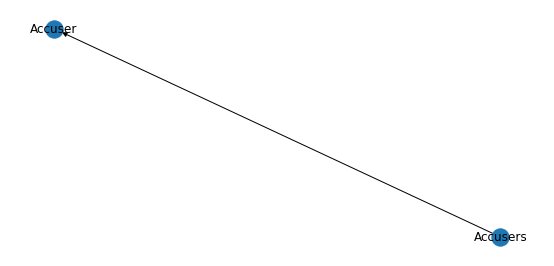

In [666]:
from matplotlib import pyplot as plt, animation
import networkx as nx
import random

#plt.style.use('dark_background')

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()

G = nx.DiGraph()
#G.add_node(teams[0])
#init = teams[0]

team = teams[0]
members = members_team[0]
egdes = 0

def update(team, member):
    print("hej")
    G.add_node(member)
    print("hejsa")
    G.add_edge(team, member)
 

def animate(frame, argu):
    print(frame)
    
    fig.clear()

    print(egdes)
    print(len(members))

    G.add_node(team)
    
    if argu != len(members):
        team_no = 0
        print("team", team)
        print("members", members)
        print("one member",members[argu])
        print("ehde",argu)
        update(team, members[argu])
        argu = argu+1
#     else:
#         egdes = egdes+ 1
        #team = team +1
    
#     G.add_node(member[0])
#     G.add_edge(team, member[0])
    
    #nx.draw(G, with_labels=True)
    
#     G.add_node(member[0])
#     G.add_edge(team, member[0])
    
    #G.add_nodes_from(members[frame])
    
#     for i in range(len(members_team[frame])):
#         G.add_node(members_team[frame][i])
#         G.add_edge(team, members_team[frame][i])
    
#     for mem in members:
#         G.add_egde(team, mem)
    
    nx.draw(G, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=2, interval=2000, repeat=True, fargs =(egdes,))

# save the animation as mp4 video file 
ani.save('graph.gif',savefig_kwargs={'facecolor':'white'}) 

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\malen\anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\malen\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


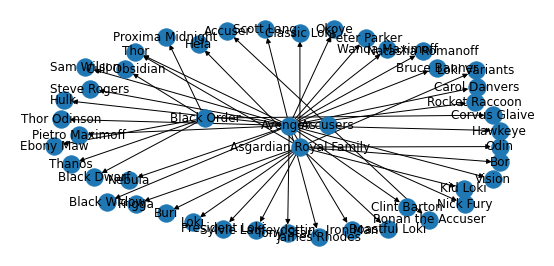

In [737]:
from matplotlib import pyplot as plt, animation
import networkx as nx
import random

#plt.style.use('dark_background')

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()

G = nx.DiGraph()
#G.add_node(teams[0])
#init = teams[0]

team = teams[0]
members = members_team[0]
egdes = 0

def animate(frame):
    fig.clear()
    i = 0
    
    dict_pairs = team_removed.items()
    pairs_iterator = iter(dict_pairs)
    team = next(pairs_iterator, frame)
    
    if frame == 0:
        G.add_node(team[0])
        G.add_nodes_from(team[1])
        for i in range(len(team[1])):
            G.add_edge(team[0],team[1][i])
    
    else:
        while i <= frame:
            team = next(pairs_iterator, frame)
            i += 1
        
        G.add_node(team[0])
        G.add_nodes_from(team[1])
        for i in range(len(team[1])):
            G.add_edge(team[0],team[1][i])

    nx.draw(G, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=4, interval=2000, repeat=True)

# save the animation as mp4 video file 
ani.save('graph.gif',savefig_kwargs={'facecolor':'white'}) 

plt.show()

In [739]:
df_characters

,name,_name
0,A'Lars,A%27Lars
1,Cammie Conroy,Cammie_Conroy
2,Campbell (Air Force),Campbell_(Air_Force)
3,Campbell (Medal of Honor),Campbell_(Medal_of_Honor)
4,Candace Daniels,Candace_Daniels
...,...,...
3316,Calvin Zabo,Calvin_Zabo
3317,Cam,Cam
3318,Cameron Klein,Cameron_Klein
3319,Cameron Tate,Cameron_Tate
